<a href="https://colab.research.google.com/github/ArthurCBx/PyTorch-DeepLearning-Udemy/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow

Resources:
* Ground truth notebook -  https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

* Book version notebook - https://www.learnpytorch.io/01_pytorch_workflow/

* Ask a question - https://github.com/mrdbourke/pytorch-deep-learning/discussions

In [ ]:
what_were_covering = {1: "data(prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating a model (inference)",
                        5: "saving and loading a model",
                        6: "putting it all together"}

In [ ]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for Neural Networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

## 1. Data (preparing and loading)

Data can be almost anything in machine learning:
* Excel spreadsheet
* Images of any kind
* Videos
* Audio like songs or podcasts
* Text

Machine learning is a game of 2 parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.
We'll use a linear regression formula to make a straight line with known *parameter*

In [ ]:
# Create *known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10],y[:10]

### Spliting data into training and test sets (one of the most important concepts in ML in general)

In general, 60-80% of the data is used to create a training set. After that, 10-20% is used in a validation set and also 10-20% is used in a testing set.

Let's create a training and test set with our data

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

How might we better visualize our data?

THis is where the data explorer's motto comes in! "Visualize,Visualize,Visualize"

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(7,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    #Plot the predictions if they exist
    plt.scatter(test_data,predictions, c="r",s=4,label="Predictions")

  # Show the legend
  plt.legend(prop={"size":12})

In [ ]:
plot_predictions()

## 2. Build model
Our first PyTorch model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through 2 main algorithms:
1. Gradient descent https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [ ]:
from torch import nn
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherit from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # Start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # Can this parameter be updated via gradient descent ?
                                                                #if True, pytorch will track gradients of this specific parameter for use with torch.autograd and gradient descent
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1, # Start with a random bias and try to adjust it to the ideal bias
                                         requires_grad=True,
                                         dtype=torch.float))
  #Forward method to define the computation in the model
  #Any subclass of nn.Moduel needs to override forward()
  def forward(self,x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # Linear regression formula


### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs ( a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set this for us
* torch.nn.Module - The base class for all neural network modules. If you subclass it, you should overwrite forward()
* torch.optim - Contains various optiizations algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss
* def forward - All nn.Module subclassess require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

In [ ]:
# List named parameters
model_0.state_dict()

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see hoe well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

In [ ]:
plot_predictions(predictions=y_preds)

### 3. Train model

The whole idea for a model to move from some *unknown* parameters (these may be random) to some *known* parameter.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how wrong your models predictions are is to use a loss function.

*Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameter (e.g. weight & bias) to improve the loss function.
  * Inside the optimizer you'll often have to set two parameters:
    * `params`- the model parameters you'd like to optmize, for ex `params=modelo_0.parameters()`
    * `lr`(learning rate) - the lr is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for pytorch, we need:
* A training loop
* A testing loop

In [ ]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr= 0.01) #lr = learning rate = possibly the most hyperparameter you can set



**Q:** Wich loss function and optimizer should I use?

**A:** This will be problem specific. but with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For ex, for a regression problem, a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.
But for a classification problem like classifying wheter a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our models `forward()` function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss(**gradient descent**)

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  #1. Forward pass
  y_pred = model_0(X_train)

  #2. Calculate the loss
  loss = loss_fn(y_pred,y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backprogation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration

  ### Testing
  model_0.eval() # turns off diferent settings in the model not needed for evaluation/testing (dropout layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  #Print out whats happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

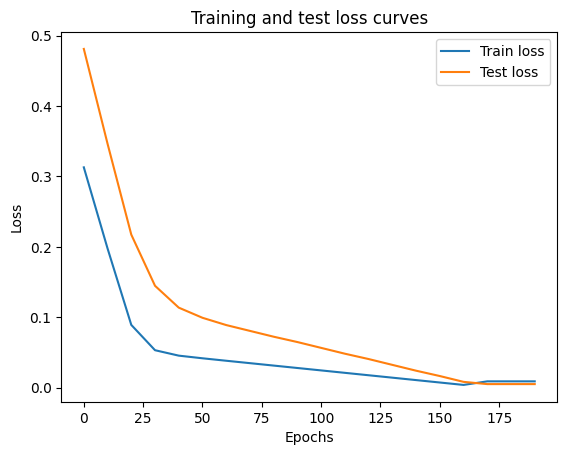

In [ ]:
import numpy as np
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

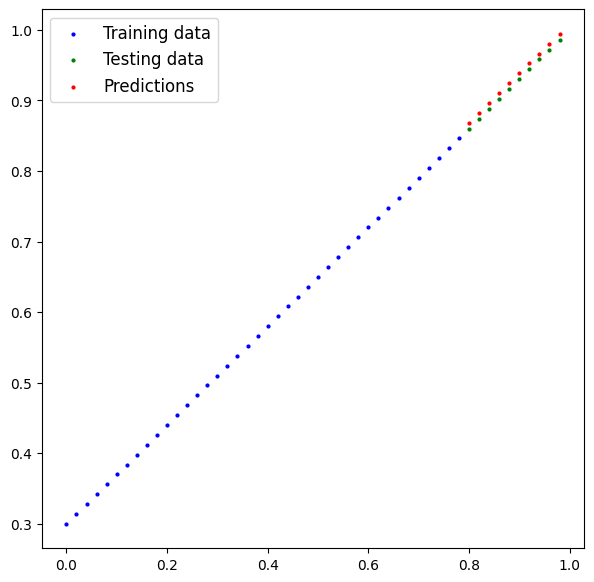

In [ ]:
with torch.inference_mode():
  y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)

## Saving a model in PyTorch

There are 3 main methods you should know about for saving and loading models in pytorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

PyTorch save & load code tutorial - https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our moedl's `state_dict()` rather the entire model,we'll create a new instance of our model class and load the saved `state_dict()` into that

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-25-09a60b055cef>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded preds with original model preds

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [ ]:
# Import PyTorch and matplotlib
import torch
import matplotlib.pyplot as plt
from torch import nn

Create device-agnostic code.

This means if we've got acess to a GPU, our code will use it (for potentially faster computing)

If no GPU is available, the code will default to using CPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### 6.1 Data


In [ ]:
# Create some data using the linear regression formula of y = wieght * X + bias
weight = 0.7
bias = 0.3

# Create range values

X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias

# Split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

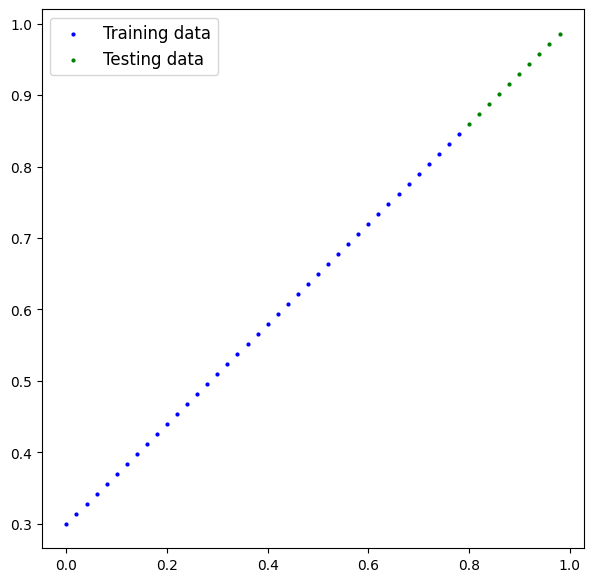

In [ ]:
def plot_predictions(train_data=X_train,
                     train_label=y_train,
                     test_data=X_test,
                     test_label=y_test,
                     predictions=None):
  plt.figure(figsize=(7,7))

  plt.scatter(train_data,train_label,c="b",s=4,label="Training data")

  plt.scatter(test_data,test_label,c="g",s=4,label="Testing data")

  if predictions != None:
    plt.scatter(test_data,predictions,c="r",s=4,label="Predictions")

  plt.legend(prop={"size":12})

plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Building a PyTorch Linear model

In [ ]:
# Create a lineaar model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    #Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, ...
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1) # 1 and 1 bc 1 value of x is equal to 1 value of y according to the linear formula

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next (model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [ ]:
# Setup the loss function
loss_fn = nn.L1Loss()

# Setup our opitimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

torch.manual_seed(42)

# Put the data on the correct device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Training loop
epochs = 200



for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred,y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")




Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating predictions

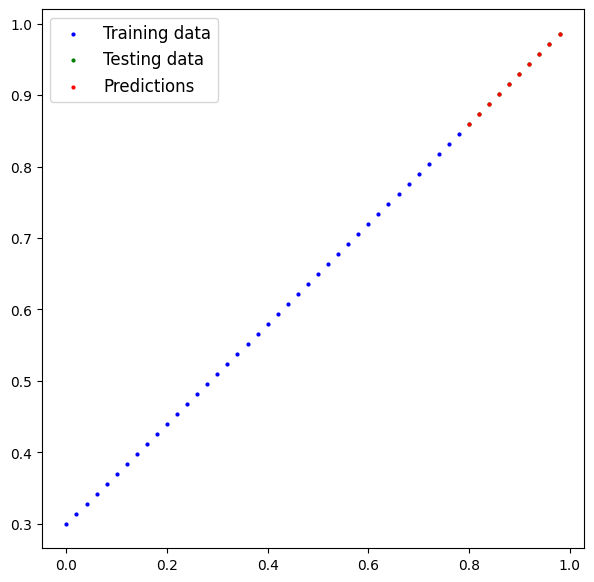

In [ ]:
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds = y_preds.cpu()
plot_predictions(predictions=y_preds)

### 6.5 Saving and loading a trained model

In [ ]:
from pathlib import Path

# 1.  create models directory
MODEL1_PATH = Path("models")
MODEL1_PATH.mkdir(parents=True,exist_ok=True)

# 2. Creatte model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL1_SAVE_PATH = MODEL1_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(),f=MODEL1_SAVE_PATH)

<ipython-input-38-28f397564017>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1_loaded.load_state_dict(torch.load(f=MODEL1_SAVE_PATH))


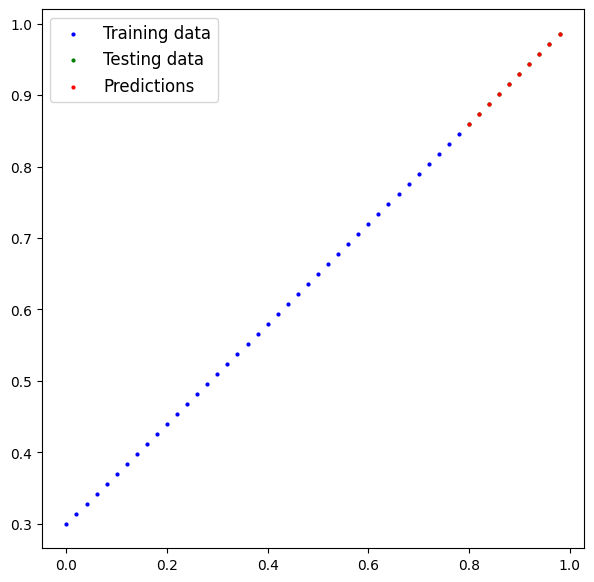

In [ ]:
# Load a PyTorch model

# Create a new instance of Linear Regression model V2
model1_loaded = LinearRegressionModelV2()

# Load the saved model_1 state_dict()
model1_loaded.load_state_dict(torch.load(f=MODEL1_SAVE_PATH))

# Put the loaded model to device
model1_loaded.to(device)
X_test = X_test.to(device)
model1_loaded.eval()
with torch.inference_mode():
  model1_loaded_preds = model1_loaded(X_test)

plot_predictions(predictions=model1_loaded_preds.cpu())

## Exercises & Extra-curriculum

In [ ]:
# Pre-exercise
import torch
import matplotlib.pyplot as plt
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

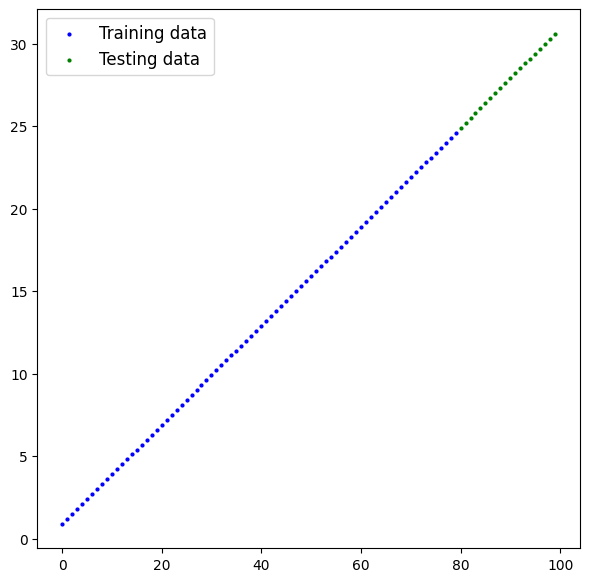

In [ ]:
# 1.Creating dataset and visualizing it
X = torch.arange(0,100,1).float().unsqueeze(dim=1)
weight = 0.3
bias = 0.9
split = int(0.8*len(X))
y = weight * X + bias

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

def plot_data(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,predictions=None):
  plt.figure(figsize=(7,7))
  plt.scatter(X_train,y_train,c="b",s=4,label="Training data")
  plt.scatter(X_test, y_test, c="g",s=4,label="Testing data")

  if predictions != None:
    plt.scatter(X_test,predictions,c="r",s=4,label="Predictions")

  plt.legend(prop={"size":12})

plot_data(X_train,y_train,X_test,y_test)

In [ ]:
# 2.Build a PyTorch model by subclassing nn.Module

class LinearRegressionModelEx(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_ex = LinearRegressionModelEx()
model_ex.to(device)
next(model_ex.parameters()).device

device(type='cuda', index=0)

In [ ]:
# 3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params,lr)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_ex.parameters(),
                            lr=0.000001)
torch.manual_seed(42)
epochs = 300

model_ex = model_ex.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_ex.train()
  #1-make the forward pass
  y_pred = model_ex(X_train)

  #2-Calculate the loss
  loss = loss_fn(y_pred,y_train)

  #3-Zero grad
  optimizer.zero_grad()

  #4-Backpropagate
  loss.backward()

  #5-Optimizer step
  optimizer.step()

  #Testing
  model_ex.eval()
  with torch.inference_mode():
      test_pred = model_ex(X_test)
      test_loss = loss_fn(test_pred,y_test)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 0.0065558068454265594 | Test loss: 0.011640834622085094
Epoch: 20 | Loss: 0.0009675078326836228 | Test loss: 0.0009950638050213456
Epoch: 40 | Loss: 0.0012670643627643585 | Test loss: 0.00032329559326171875
Epoch: 60 | Loss: 0.0013579301303252578 | Test loss: 0.00013208389282226562
Epoch: 80 | Loss: 0.0012538641458377242 | Test loss: 0.00035696031409315765
Epoch: 100 | Loss: 0.0010852999985218048 | Test loss: 0.0007471084827557206
Epoch: 120 | Loss: 0.0013255588710308075 | Test loss: 0.000211620339541696
Epoch: 140 | Loss: 0.0010525815887376666 | Test loss: 0.0008070945623330772
Epoch: 160 | Loss: 0.0013079465134069324 | Test loss: 0.0002556800900492817
Epoch: 180 | Loss: 0.0009854503441601992 | Test loss: 0.0009660720825195312
Epoch: 200 | Loss: 0.0012555159628391266 | Test loss: 0.00037984849768690765
Epoch: 220 | Loss: 0.0014486946165561676 | Test loss: 4.8923491704044864e-05
Epoch: 240 | Loss: 0.001324702869169414 | Test loss: 0.00022401810565497726
Epoch: 260 | Lo

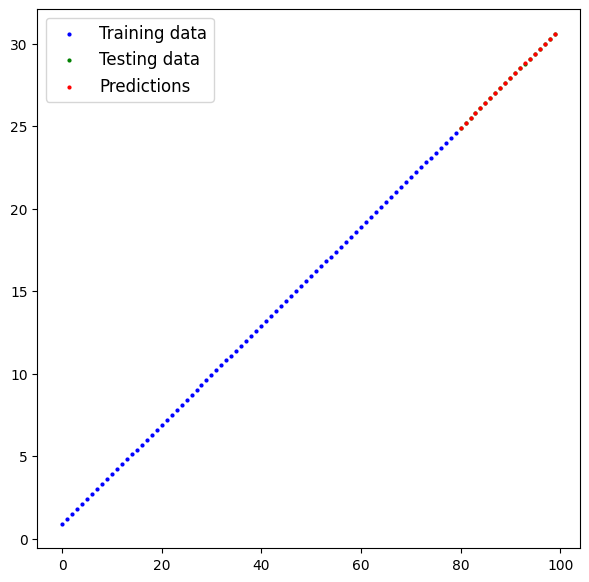

In [ ]:
with torch.inference_mode():
  y_preds = model_ex(X_test)

plot_data(predictions=y_preds.cpu())

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_ex.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_ex.state_dict(),f=MODEL_SAVE_PATH)